# Transfer learning

For an example of transfer learning in TensorFlow for a computer vision task, let's use a 
1. pre-trained model from TensorFlow's Keras Applications, 
2. fine-tune it on a smaller dataset, 
3. improve its performance for a specific task. 
4. 
5. This example will demonstrate how to adapt a **`MobileNetV2 model`**, **pre-trained on ImageNet**, for a new classification task using the `CIFAR-10 dataset—a collection of 60,000 32x32 color images in 10 different classes.`

### Step 1: Import Libraries and Load Data

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values and convert labels to one-hot encoding
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

170498071/170498071 [==============================] - 21s 0us/step


### `Data Augmentation:`

Data augmentation is a strategy used in machine learning to increase the diversity and amount of training data without actually collecting new data. This is achieved by creating modified versions of the existing data. For example, in image data, augmentation techniques might include rotation, scaling, flipping, cropping, or adding noise.

Data augmentation is beneficial for several reasons:

1. **`Preventing Overfitting`**: By providing more varied data, the model is less likely to memorize the training data and more likely to generalize to new, unseen data.
2. **`Improving Model Performance`**: More data generally leads to better model performance, especially in deep learning.
3. **`Dealing with Imbalanced Data`**: Augmentation can help balance the dataset by creating more instances of under-represented classes.

Remember, the type of augmentation should make sense for the problem at hand. For example, flipping an image might be fine for a general object recognition task, but not for a task where `orientation is crucial, like reading numbers` or letters.

### Step 2: Preprocess Data

Since MobileNetV2 expects input images of size `224x224`, and CIFAR-10 images are `32x32`, we need to resize them. We'll also apply some data augmentation:


In [2]:
# Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    fill_mode='nearest')

datagen.fit(x_train)

### Step 3: Modify Pre-trained Model

We'll load `MobileNetV2` without its top layer (since we're applying it to a new task with 10 classes instead of 1000), add a new classifier on top, and freeze the layers of MobileNetV2:

**We use less classes than 1000**

In [3]:
# Load MobileNetV2 without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base_model
base_model.trainable = False 

# Add custom layers on top for our task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # New FC layer, random init
predictions = Dense(10, activation='softmax')(x)  # New softmax layer

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

2024-02-12 22:49:07.234408: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-02-12 22:49:07.234428: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 96.00 GB
2024-02-12 22:49:07.234433: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 36.00 GB
2024-02-12 22:49:07.234463: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-12 22:49:07.234477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


9406464/9406464 [==============================] - 1s 0us/step


### Step 4: Compile and Train the Model

In [4]:
%%time
model.compile(optimizer=tf.keras.optimizers.Adam(), 
loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), 
                    steps_per_epoch=len(x_train) / 32, epochs=10,
                    validation_data=(x_test, y_test), verbose=1)

Epoch 1/10


2024-02-12 15:33:09.148689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1562/1562 [============================>.] - ETA: 0s - loss: 1.9887 - accuracy: 0.2723

2024-02-12 15:33:51.798250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1562/1562 [==============================] - 51s 30ms/step - loss: 1.9886 - accuracy: 0.2723 - val_loss: 1.9712 - val_accuracy: 0.2867
Epoch 2/10
1562/1562 [==============================] - 47s 30ms/step - loss: 1.9846 - accuracy: 0.2766 - val_loss: 1.9952 - val_accuracy: 0.2647
Epoch 3/10
1562/1562 [==============================] - 46s 30ms/step - loss: 2.0009 - accuracy: 0.2693 - val_loss: 1.9953 - val_accuracy: 0.2772
Epoch 4/10
1562/1562 [==============================] - 47s 30ms/step - loss: 2.0104 - accuracy: 0.2682 - val_loss: 1.9812 - val_accuracy: 0.2851
Epoch 5/10
1562/1562 [==============================] - 47s 30ms/step - loss: 2.0238 - accuracy: 0.2658 - val_loss: 2.0269 - val_accuracy: 0.2701
Epoch 6/10
1562/1562 [==============================] - 45s 29ms/step - loss: 2.0335 - accuracy: 0.2633 - val_loss: 2.0611 - val_accuracy: 0.2564
Epoch 7/10
1562/1562 [==============================] - 45s 29ms/step - loss: 2.0555 - accuracy: 0.2563 - val_loss: 1.9941 - val_accura

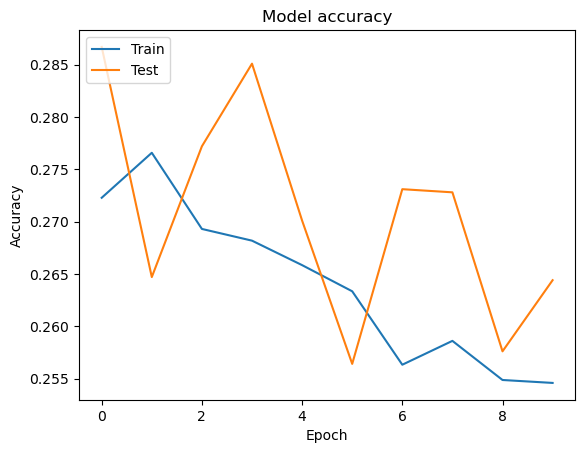

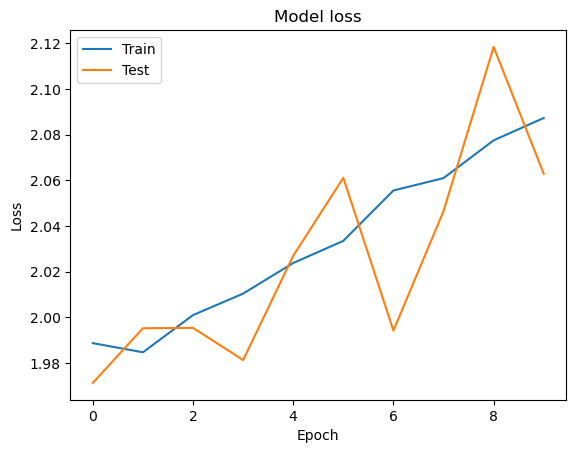

In [9]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# An extra run with more epochs and Increased Batch Size

Epoch 1/50
781/781 [==============================] - 26s 32ms/step - loss: 1.8656 - accuracy: 0.3192 - val_loss: 1.8303 - val_accuracy: 0.3352
Epoch 2/50
781/781 [==============================] - 24s 31ms/step - loss: 1.8540 - accuracy: 0.3253 - val_loss: 1.8108 - val_accuracy: 0.3478
Epoch 3/50
781/781 [==============================] - 24s 30ms/step - loss: 1.8366 - accuracy: 0.3309 - val_loss: 1.7965 - val_accuracy: 0.3503
Epoch 4/50
781/781 [==============================] - 23s 30ms/step - loss: 1.8286 - accuracy: 0.3361 - val_loss: 1.7952 - val_accuracy: 0.3523
Epoch 5/50
781/781 [==============================] - 24s 31ms/step - loss: 1.8184 - accuracy: 0.3400 - val_loss: 1.7919 - val_accuracy: 0.3519
Epoch 6/50
781/781 [==============================] - 24s 30ms/step - loss: 1.8172 - accuracy: 0.3374 - val_loss: 1.7924 - val_accuracy: 0.3518
Epoch 7/50
781/781 [==============================] - 23s 30ms/step - loss: 1.8110 - accuracy: 0.3424 - val_loss: 1.7811 - val_accuracy:

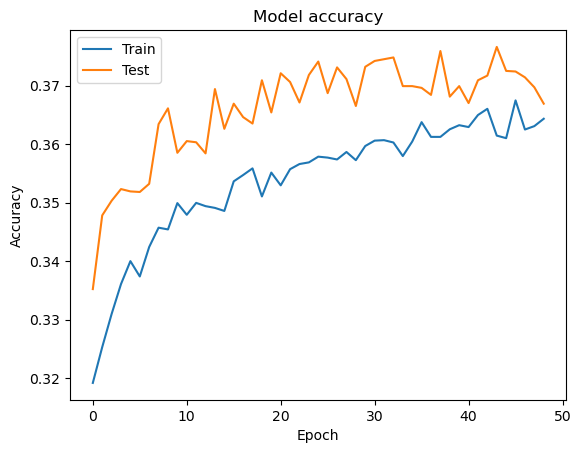

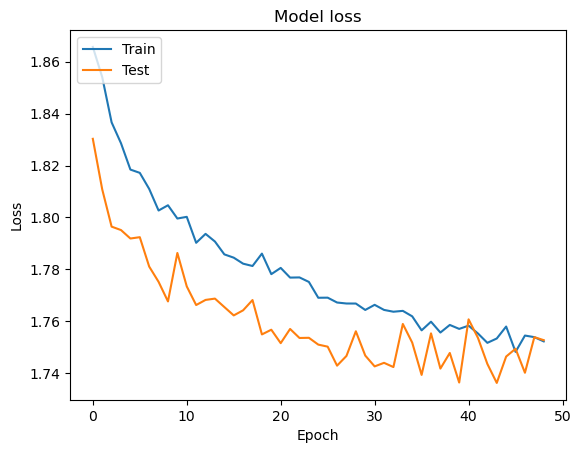

CPU times: user 24min 54s, sys: 3min 19s, total: 28min 13s
Wall time: 19min 15s


In [5]:
%%time
#early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(), 
loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), 
                    steps_per_epoch=len(x_train) / 64, epochs=50,
                    validation_data=(x_test, y_test), verbose=1, callbacks=[early_stopping])
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Step 5: Fine-Tuning (Optional)

After the initial training with the top layers, you can choose to unfreeze some of the bottom layers of the MobileNetV2 model and `continue training to improve accuracy`. Before doing so, it's important to recompile the model:

In [10]:
# Unfreeze some layers in the base model
base_model.trainable = True
fine_tune_at = 100  # This is the number of layers from the top to freeze
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                         steps_per_epoch=len(x_train) / 32, epochs=5,
                         validation_data=(x_test, y_test), verbose=1)

Epoch 1/5


2024-02-12 15:44:16.333971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1562/1562 [============================>.] - ETA: 0s - loss: 3.1965 - accuracy: 0.3694

2024-02-12 15:45:25.587078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1562/1562 [==============================] - 78s 47ms/step - loss: 3.1965 - accuracy: 0.3694 - val_loss: 3.0576 - val_accuracy: 0.3567
Epoch 2/5
1562/1562 [==============================] - 71s 45ms/step - loss: 3.5205 - accuracy: 0.4662 - val_loss: 14.4716 - val_accuracy: 0.4929
Epoch 3/5
1562/1562 [==============================] - 72s 46ms/step - loss: 3.4764 - accuracy: 0.4872 - val_loss: 3.3241 - val_accuracy: 0.3772
Epoch 4/5
1562/1562 [==============================] - 73s 47ms/step - loss: 3.7591 - accuracy: 0.4746 - val_loss: 59.3385 - val_accuracy: 0.2270
Epoch 5/5
1562/1562 [==============================] - 71s 45ms/step - loss: 3.5902 - accuracy: 0.4824 - val_loss: 5.2116 - val_accuracy: 0.4303


This example demonstrates the basics of applying transfer learning with TensorFlow to improve performance on a computer vision task using a smaller dataset. Fine-tuning and data augmentation are powerful techniques to increase accuracy further and adapt the pre-trained model to the new task more effectively.

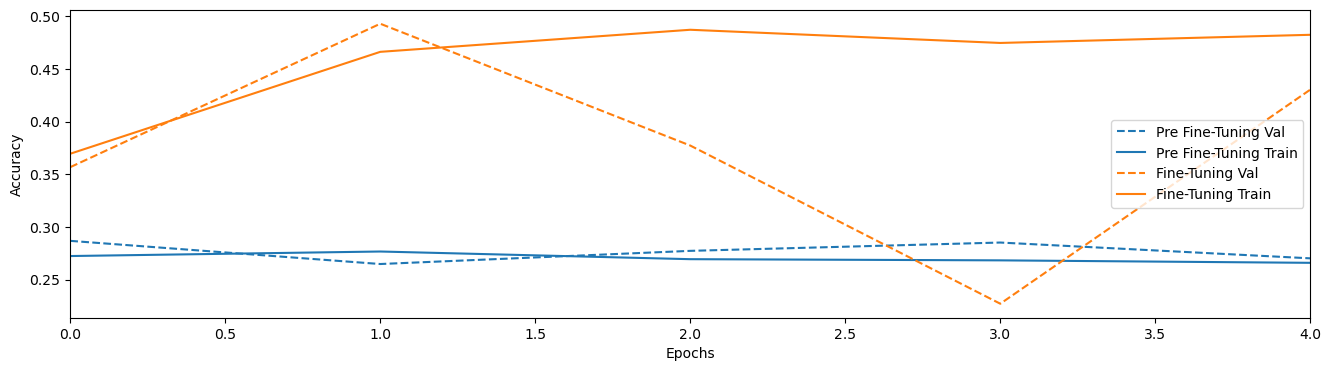

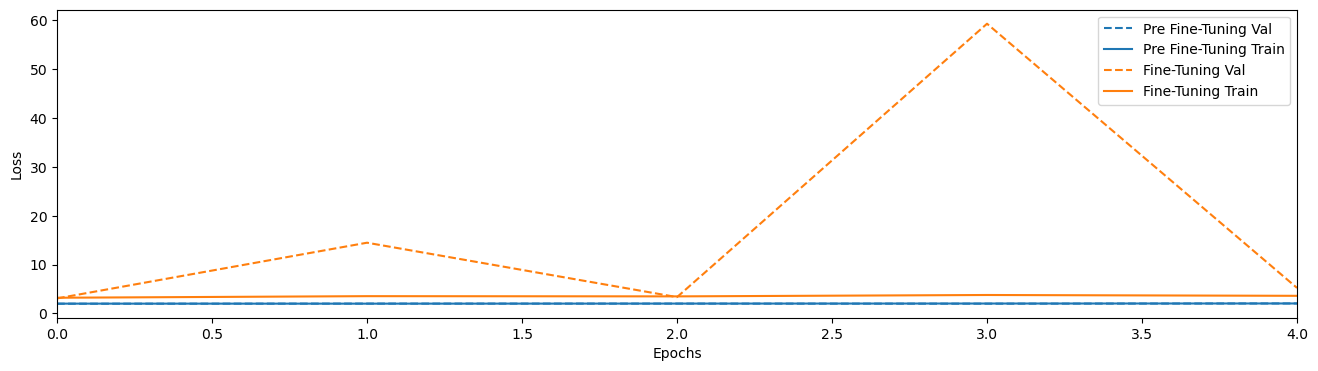

In [14]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(16, 4))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()
    plt.xlim([0, max(history.epoch)])

# Plot accuracy
plot_history([('Pre Fine-Tuning', history),
              ('Fine-Tuning', history_fine)],
             key='accuracy')

# Plot loss
plot_history([('Pre Fine-Tuning', history),
              ('Fine-Tuning', history_fine)],
             key='loss')